In [1]:
import torch
from torch import nn
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


In [22]:
transform = T.Compose([T.ToTensor(), 
         # Переводим цвета пикселей в отрезок [-1, 1]
         T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = CIFAR10('.CIFAR10', transform=transform , train=True, download=True)
test_set = CIFAR10('.CIFAR10', transform=transform , train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
class LeNet(nn.Module):
    def __init__(self, image_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(# 32 x 32
            
            nn.Conv2d(in_channels=image_channels, out_channels=6, kernel_size=5), # 28 x 28
            nn.Tanh(), # т.к. поэлементный ничего не поменяет
            nn.AvgPool2d(2), # 14 x 14
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), # 10 x 10
            nn.Tanh(),
            nn.AvgPool2d(2), # 5 x 5
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5) # 1 x 1
        ) #карта признаков из 4-х мерной стала 2-х мерной ( остался только Batch и каналы )
        
        self.head = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(), 
            nn.Linear(in_features=84, out_features=10)   
        )
        
    def forward(self,x):
        # x: B x 1 x 32 x 32
        out = self.encoder(x)
        # out: B x 120 x 1 x 1
        #сплющиваем это дело по двум последним координатам 
        out = out.squeeze(-1).squeeze(-1)
        #out: B x 120
        out = self.head(out)
        # out: B x 10
        return out

In [134]:
class ResNet(nn.Module):
    
    def __init__(self, image_channels=1):
        super().__init__()
        self.encoder_part1 = nn.Sequential( # 32 x 32
            nn.Conv2d(in_channels=image_channels, out_channels=32, kernel_size=3,stride=1, padding=1), # 32 x  32
            nn.BatchNorm2d(num_features=32), # 32 x 32
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32)
        )
        self.encoder_part2 = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
            )
        self.encoder = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8)
            )
        self.head = nn.Sequential(
            nn.Linear(in_features=512, out_features=10)
            )
        
    def forward(self,x): 
        
        out1 = self.encoder_part1(x)
        #print(out1.shape)
        out2 = self.encoder_part2(x)
        #print(out2.shape)
        sum_out = torch.add(out1, out2)
        #print(sum_out.shape)
        out = self.encoder(sum_out)
        #print(out.shape)
        #out = out.squeeze(-1).squeeze(-1) # !!!!
        out = torch.flatten(out, start_dim=1)
        #print(out.shape)
        out = self.head(out)
        
        return out

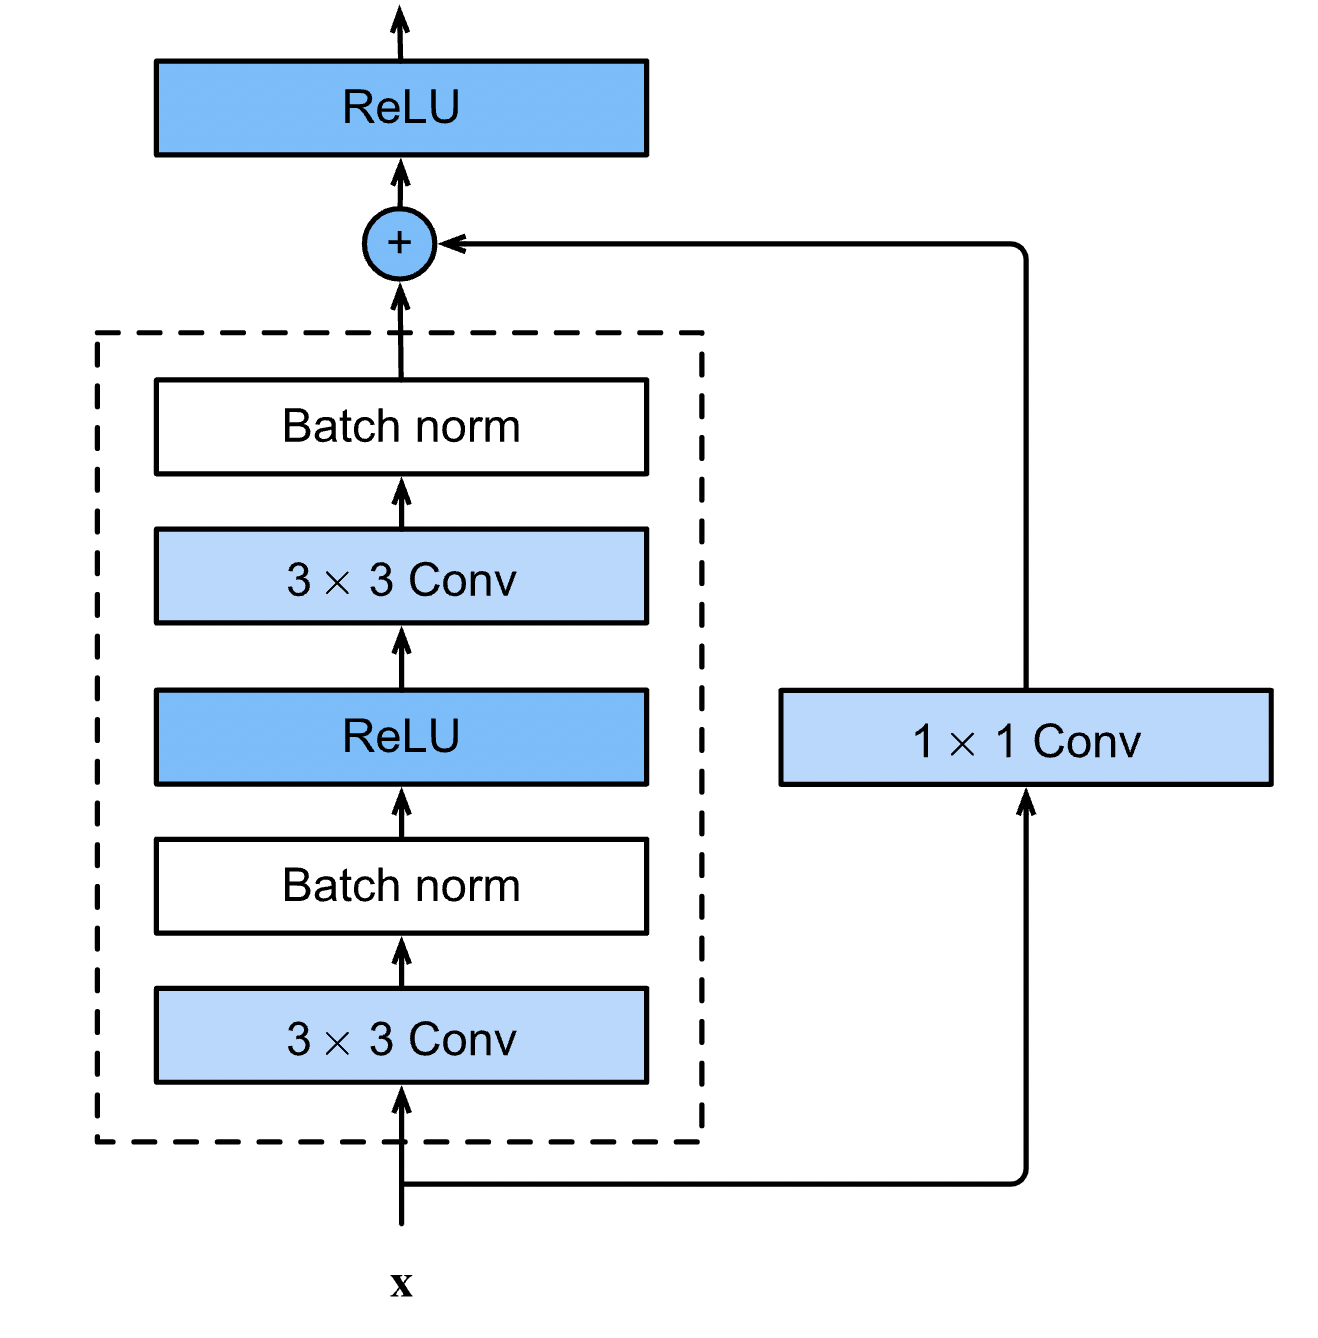

In [135]:
def train_test_model():
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_accuracy = 0.0, 0.0
        model.train()
        for images, labels in tqdm(train_loader, desc="TRAIN"):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            #images: batch_size x num_channels x height x weights
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.shape[0]
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
            
        if scheduler is not None:
            scheduler.step()
        
        train_loss /= len(train_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        
        test_loss, test_accuracy = 0.0, 0.0
        model.eval()
        for images, labels in tqdm(test_loader, desc = "VALIDATION"):
            
            images = images.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                logits = model(images)
                loss = criterion(logits, labels)
            
            test_loss += loss.item() * images.shape[0]
            test_accuracy += (logits.argmax(dim=1) == labels).sum().item()
            
        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset)
        
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)   

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 15})

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13,4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label ='test')
    axs[0].set_ylabel('loss')
    
    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')
    
    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()
    
    plt.show()

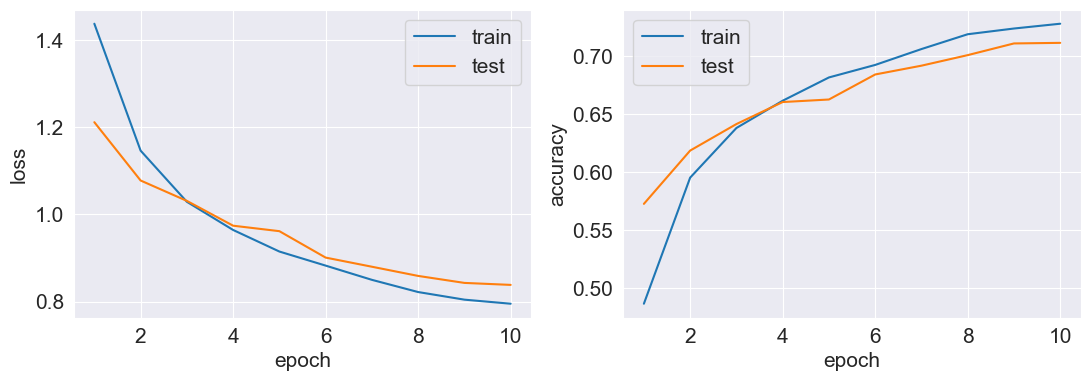

In [137]:
NUM_EPOCHS = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet(image_channels=3).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()
train_test_model()